In [12]:
import sys
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\TP4_ECAL-\\utils')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\tracking')
from data_loading import *
from tqdm import tqdm
from hit import Hit
from track3D import Track3D
from matplotlib import pyplot as plt
from track_reconstruction3D import*

file_path = 'C:\\Users\\Pascal\\Desktop\\TP4a\\data\\run_000002\\data_0000.root' 
import pandas as pd
import uproot
import numpy as np

In [13]:
br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'evt_flags']
evt_tree = 'event_data;1'
hits_tree = 'event_data;1'

In [14]:
with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
df_evts = pd.DataFrame.from_dict(evts_dict)
df_hits = pd.DataFrame.from_dict(hits_dict)
df_hits['timestamp_event'] = df_evts['timestamp']

In [15]:
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)

            ## check if track has a "good" chi2 value
            if track.is_good_2D_fit():
            
                # worth making a precise track
                #track.precise_track()
                
                ## compute the time of the track
                dt = track.get_time_interval()
                if dt is not None:
                    dts.append(dt)


    return tracks, dts
    

In [16]:
trackss, dts = create_tracks(df_hits[0:200])

100%|██████████| 200/200 [00:04<00:00, 48.87it/s] 


[0.3534291735288517,
 4.900884539600077,
 26.095999999999997,
 -0.09599999999999966,
 14.200000000000001,
 4.953539595641917]

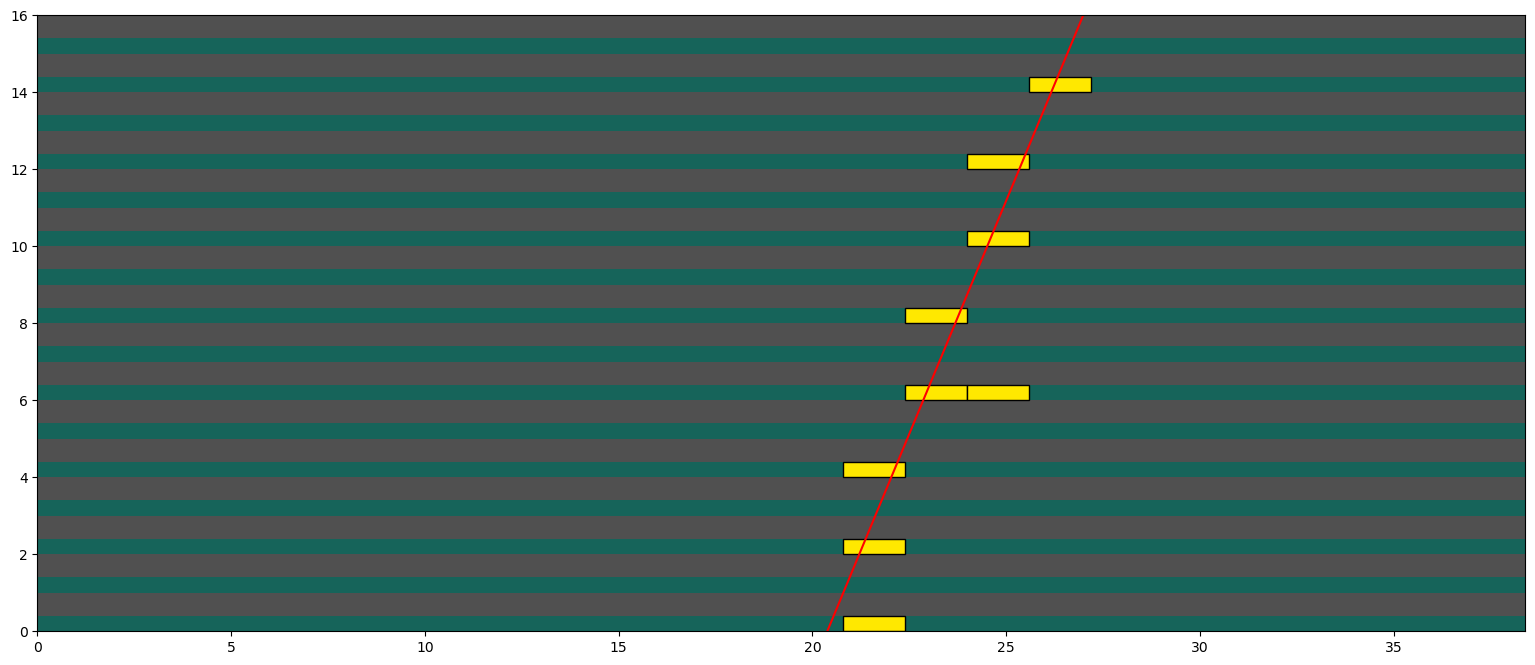

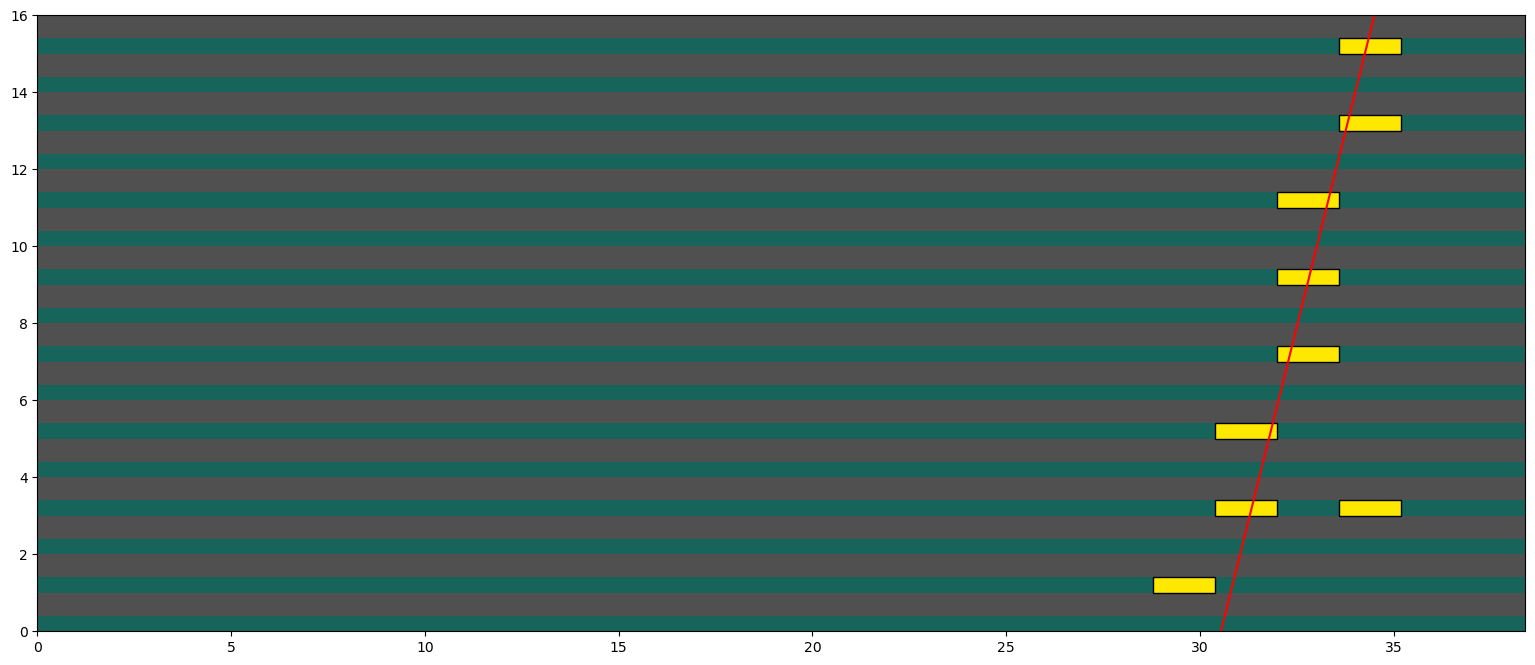

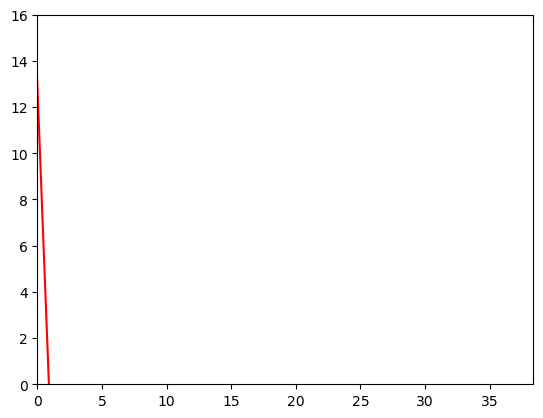

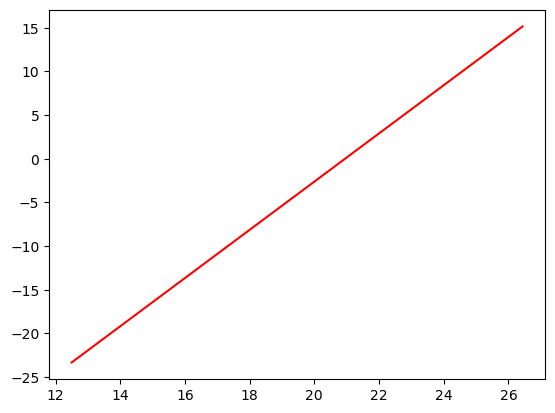

In [19]:

t1 = trackss[5]
tt_x = t1.x
tt_y = t1.y
hitst1 = tt_x.hits
hitst2 = tt_y.hits

HH = hitst1+ hitst2

fig, axs=plot_hits(hitst1,True)
z = np.linspace(0,16,50)
x = tt_x.x(z)
axs.plot(x,z,'r-')
fig, axs=plot_hits(tt_y.hits,False)
z = np.linspace(0,16,50)
x = tt_y.x(z)
axs.plot(x,z,'r-')

find_3Dcurve(hitst1,2,True)